In [ ]:
model = torch.load(model_path)
model['hyper_parameters']['autoencoder_checkpoint'] = '/home/john/PhD/BISCUIT/pretrained_models/AE_gridworld_simplified/AE_40l_64hid.ckpt'
torch.save(model, model_path)

In [1]:
from models.biscuit_nf import BISCUITNF
import torch
from typing import List, Tuple, Dict, Any, Union, Optional
device = 'cuda' if torch.cuda.is_available() else 'cpu'

autoencoder_path = '/home/john/PhD/BISCUIT/pretrained_models/AE_40l_64hid_3c1b3l.ckpt'
model_path = '/home/john/PhD/BISCUIT/pretrained_models/epoch=39-step=19760.ckpt'
model = BISCUITNF.load_from_checkpoint(model_path, autoencoder_path=autoencoder_path)
model.to(device)
model.freeze()
_ = model.eval()



/home/john/miniconda3/envs/biscuit/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/john/miniconda3/envs/biscuit/lib/python3.11/site-packages/pytorch_lightning/utilities/migration/utils.py:55: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.1.0, which is newer than your current Lightning version: v2.0.9.post0
  rank_zero_warn(


In [ ]:
import torch
encs_path = '/home/john/PhD/BISCUIT/pretrained_models/AE_gridworld_simplified/encodings/gridworld_simplified_5c_test_indep.pt'
encs_path_drop_last_frame = '/home/john/PhD/BISCUIT/pretrained_models/AE_gridworld_simplified/encodings/gridworld_simplified_5c_drop_last_frame_test_indep.pt'
t = torch.load(encs_path)
t1 = torch.load(encs_path_drop_last_frame)


In [ ]:
from matplotlib import pyplot as plt
for i in range(50):
    print(i)
    img1 = t1[i]
    img2 = t[i]
    print(img1)
    print(img2)
    img1 = model.autoencoder.decoder(torch.from_numpy(img1).to(device).unsqueeze(0))
    img1 = (img1 + 1) / 2
    img2 = model.autoencoder.decoder(torch.from_numpy(img2).to(device).unsqueeze(0))
    img2 = (img2 + 1) / 2
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img1.squeeze().cpu().detach().numpy().transpose(1, 2, 0))
    ax[1].imshow(img2.squeeze().cpu().detach().numpy().transpose(1, 2, 0))
    plt.show()


In [ ]:
encodings_path = '/home/gkounto/BISCUIT/experiments/pretrained_models/AE_gridworld_small/encodings/gridworld_small_pre_intv_freeze_test.pt'
encodings = torch.load(encodings_path)

In [3]:
from experiments.datasets import GridworldDataset
data_folder = '/home/john/PhD/BISCUIT/data_generation/data/gridworld_simplified_3c1b3l_noturn_noshufflecars_f'
# val_seq_dataset = GridworldDataset(
# data_folder=data_folder, split='val', return_targets=True, return_robot_state=True, single_image=False, triplet=False, seq_len=2, cluster=False, return_text=False, subsample_percentage=0.01)
train_seq_dataset = GridworldDataset(
        data_folder=data_folder, split='val', return_targets=True, return_latents=True, single_image=False, triplet=False, seq_len=2, cluster=False, return_text=True, subsample_percentage=0.5)

1000


Loading sequences of val:   0%|          | 0/1000 [00:00<?, ?it/s]

In [80]:
import torch
from torch.utils.data import DataLoader
from experiments.datasets import GridworldDataset
from tqdm import tqdm
def encode_dataset(model, dataloader, device):
    model.eval()
    all_latents = []

    with torch.no_grad():
        # Wrap the dataloader with tqdm for a progress bar
        for batch in tqdm(dataloader, desc="Encoding batches"):
            # Assuming batch[0] is the input data
            inputs = batch[0].to(device)
            latents = model.autoencoder.encoder(inputs)
            disentangled_latents = model.encode(latents)
            all_latents.append(disentangled_latents.cpu())

    # Concatenate all batch outputs into a single tensor
    all_latents = torch.cat(all_latents, dim=0)
    return all_latents

def identify_prunable_latents(latents, std_threshold=0.1):
    # Calculate the standard deviation across the batch dimension
    stds = torch.std(latents, dim=0)
    print(stds)
    prunable_indices = torch.where(stds < std_threshold)[0]
    return prunable_indices

# Parameters
data_folder = '/home/john/PhD/BISCUIT/data/gridworld_simplified_5c'
batch_size = 64  # Adjust batch size according to your GPU memory
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Setup dataset and dataloader
# train_dataset = GridworldDataset(data_folder=data_folder, split='val', return_targets=True,
#                                  return_latents=True, single_image=True, triplet=False, seq_len=2,
#                                  cluster=False, return_text=True, subsample_percentage=1.0)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Encode all data
model.to(device)
all_disentangled_latents = encode_dataset(model, train_loader, device)

# Identify prunable latents
prunable_indices = identify_prunable_latents(all_disentangled_latents)
print(f"Latent dimensions that can be pruned: {prunable_indices.tolist()}")

tensor([4.3245, 3.7136, 4.1374, 4.3170, 4.1890, 3.9721, 3.5552, 4.6210, 3.5418,
        5.3126, 3.4409, 5.0134, 1.9434, 2.2111, 1.3638, 1.3471, 1.8532, 6.8994,
        1.6336, 7.0921])
Latent dimensions that can be pruned: []


In [82]:
identify_prunable_latents(all_disentangled_latents, std_threshold=3.)

tensor([4.3245, 3.7136, 4.1374, 4.3170, 4.1890, 3.9721, 3.5552, 4.6210, 3.5418,
        5.3126, 3.4409, 5.0134, 1.9434, 2.2111, 1.3638, 1.3471, 1.8532, 6.8994,
        1.6336, 7.0921])


tensor([12, 13, 14, 15, 16, 18])

In [83]:
import torch
from torch.utils.data import DataLoader
from experiments.datasets import GridworldDataset
from transformers import AutoTokenizer
from tqdm import tqdm
from open_clip import create_model_from_pretrained, get_tokenizer
model_name = 'hf-hub:timm/ViT-B-16-SigLIP'
tokenizer = get_tokenizer(model_name)


# Initialize the tokenizer
# model_name = 'sentence-transformers/all-MiniLM-L6-v2'
# tokenizer = AutoTokenizer.from_pretrained(model_name)

def process_data(model, dataloader, prune_dims, device):
    model.eval()
    data_tuples = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Processing data"):
            # Extract data components
            image_pairs, input_ids, token_type_ids, attention_mask = batch[0], batch[-4], batch[-3], batch[-2]

            # Decode text descriptions
            action_descriptions = [
                tokenizer.tokenizer.decode(ids[mask.bool()].tolist(), skip_special_tokens=True)
                for ids, mask in zip(input_ids, attention_mask)
            ]

            # Process each pair of images
            for images, action_description in zip(image_pairs, action_descriptions):
                # Encode images to latents and then to disentangled latents
                s0, s1 = images[0].to(device), images[1].to(device)
                latent_s0 = model.autoencoder.encoder(s0.unsqueeze(0))
                latent_s1 = model.autoencoder.encoder(s1.unsqueeze(0))
                disentangled_s0 = model.encode(latent_s0).squeeze(0)
                disentangled_s1 = model.encode(latent_s1).squeeze(0)

                # Prune specific latent dimensions using the prune_dims list
                pruned_s0 = torch.index_select(disentangled_s0, 0, torch.tensor(prune_dims, device=device))
                pruned_s1 = torch.index_select(disentangled_s1, 0, torch.tensor(prune_dims, device=device))

                # Store the tuple (pruned_s0, action_description, pruned_s1)
                data_tuples.append((pruned_s0.cpu(), action_description, pruned_s1.cpu()))

    return data_tuples

# Parameters
data_folder = '/home/john/PhD/BISCUIT/data/gridworld_simplified_5c'
batch_size = 32  # Adjusted for processing two images per sample
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Setup dataset and dataloader
train_dataset = GridworldDataset(data_folder=data_folder, split='train', return_targets=True,
                                 return_latents=True, single_image=False, triplet=False, seq_len=2,
                                 cluster=False, return_text=True, subsample_percentage=0.005)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# Process data
model.to(device)
data_tuples = process_data(model, train_loader, list(set(range(20)) - set([12, 13, 14, 15, 16, 18])), device)

# Display some samples
for i in range(3):
    print(f"Sample {i+1}:")
    print("Pruned Latent s0:", data_tuples[i][0])
    print("Action Description:", data_tuples[i][1])
    print("Pruned Latent s1:", data_tuples[i][2])
    print()

50


Processing data: 100%|██████████| 30/30 [00:35<00:00,  1.18s/it]            

Sample 1:
Pruned Latent s0: tensor([-5.1105, -0.0313,  2.5049,  4.8884,  3.1617, -0.0855, -2.1020,  9.1485,
        -4.7292, -3.7658,  4.6165, -9.4115,  4.8306,  2.4634])
Action Description: You skillfully changed the state of the sturdy, illuminated, silver traffic light.
Pruned Latent s1: tensor([ -5.0844,  -0.5309,   2.9766,  -3.4161,   4.3827,   0.3204,  -0.3343,
          8.6096,  -4.4251,  -5.7085,   4.1223, -10.9092,   4.7426,   4.8466])

Sample 2:
Pruned Latent s0: tensor([ -4.5394,  -0.1422,   3.6258,  -4.3175,   3.7612,   0.3745,  -1.8695,
          9.6974,  -4.9644,  -4.1669,   3.7390, -12.9657,   4.2706,   4.8516])
Action Description: You efficiently changed the state of the metal, tall, cyan traffic light.
Pruned Latent s1: tensor([-5.1930, -0.3977,  1.6693, -4.9367,  4.6385, -0.6891, -1.6269,  9.2834,
        -5.6118,  7.2611,  4.5844, -9.9984,  4.5780,  3.3895])

Sample 3:
Pruned Latent s0: tensor([ -4.2777,   0.5108,   3.6823,  -3.7846,   4.4797,  -0.9899,  -3.1272,
   

In [ ]:
def format_data_tuples(data_tuples, num_samples):
    sequence_strings = []
    for i, (s0, desc, s1) in enumerate(data_tuples[:num_samples]):
        # Format tensors with two decimal places
        s0_formatted = ', '.join(f"{x:.2f}" for x in s0.numpy())
        s1_formatted = ', '.join(f"{x:.2f}" for x in s1.numpy())

        # Create the sequence string for the current tuple
        sequence_string = f"Seq{i+1}: <[{s0_formatted}], {desc}, [{s1_formatted}]>"
        sequence_strings.append(sequence_string)

    # Combine all sequence strings into one
    full_sequence = ' '.join(sequence_strings)
    return full_sequence

# Define the number of sequences you want to generate in the string
num_sequences = 30  # Change this number based on your requirements

# Generate formatted sequence string
formatted_sequences = format_data_tuples(data_tuples, num_sequences)
print(formatted_sequences)


In [84]:
import json

def create_json_from_tuples(data_tuples, num_samples):
    sequences = {}
    for i, (s0, desc, s1) in enumerate(data_tuples[:num_samples], start=1):
        # Convert tensors to formatted lists
        s0_list = [f"{x:.2f}" for x in s0.numpy()]
        s1_list = [f"{x:.2f}" for x in s1.numpy()]

        # Create a dictionary for the current sequence
        sequence_dict = {
            "s_0": s0_list,
            "a": desc,
            "s_1": s1_list
        }

        # Add the dictionary to the sequences with a key indicating the sequence number
        sequences[f"seq{i}"] = sequence_dict

    # Convert the dictionary to JSON
    json_output = json.dumps(sequences, indent=4)
    return json_output

# Define the number of sequences you want to convert into JSON
num_sequences = 300  # Adjust this to include more or fewer sequences

# Create JSON from the data tuples
json_sequences = create_json_from_tuples(data_tuples, num_sequences)
# print(json_sequences)
# Save json
with open('pruned_sequences.json', 'w') as f:
    f.write(json_sequences)


In [ ]:
import numpy as np
import json
from data_generation.gridworld import Gridworld
from PIL import Image
import matplotlib.pyplot as plt

def format_causal_dict(causal_dict):
    formatted_text = ""
    for key, value in causal_dict.items():
        formatted_text += f"{key}: {value}\n"
        if "position_y" in key:  # Add a line break after each entity's details
            formatted_text += "\n"
    return formatted_text

def visualize_episode(frames, causals, causal_keys, actions, action_descriptions, interventions):
    for i in range(len(frames)):
        # debug_causals = Gridworld.causal_vector_to_debug_dict(causal_keys, causals[i])
        debug_causals = dict(zip(causal_keys, causals[i]))
        formatted_causals = format_causal_dict(debug_causals)

        fig, ax = plt.subplots(figsize=(10, 6))
        ax1 = plt.subplot(1, 2, 1)  # Frame subplot
        ax1.imshow(frames[i])
        ax1.set_title(f"Frame {i+1}")
        ax1.axis('off')

        ax2 = plt.subplot(1, 2, 2)  # Textual information subplot
        ax2.axis('off')
        text_info = (
            f"Step {i+1}:\n\n"
            f"Causals (Formatted):\n{formatted_causals}\n"
            f"Action: {actions[i]}\n"
            f"Action Description: {action_descriptions[i]}\n"
            f"Interventions: {interventions[i]}"
        )
        ax2.text(0, 1, text_info, ha='left', va='top', fontsize=8, wrap=True)

        plt.tight_layout()
        plt.show()

a = np.load('/home/john/PhD/BISCUIT/data_generation/data/gridworld_simplified_2c2b2l_noturn_noshufflecars/check/gridworld_episode_28.npz')
causal_keys = json.load(open('/home/john/PhD/BISCUIT/data_generation/data/gridworld_simplified_2c2b2l_noturn_noshufflecars/check_metadata.json'))['flattened_causals']
frames, causals, actions, interventions, action_descriptions = a['frames'], a['causals'], a['actions'], a['interventions'], a['action_descriptions']
visualize_episode(frames, causals, causal_keys, actions, action_descriptions, interventions)

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import json
# Assume Gridworld, format_causal_dict, and the dataset class are defined elsewhere

def visualize_episodes(dataset, causal_keys, N=1):
    for episode_idx in range(min(N, len(dataset))):  # Loop through N episodes or the total dataset length
        frame_seq = dataset[episode_idx]  # Get the episode data
        frames, actions, interventions, causals = frame_seq
        
        for i in range(frames.shape[0] - 1):  # Iterate through each step, excluding the last frame
            # Map causals to keys for the current frame
            debug_causals = dict(zip(causal_keys, causals[i]))
            formatted_causals = format_causal_dict(debug_causals)

            fig, ax = plt.subplots(figsize=(10, 6))
            ax1 = plt.subplot(1, 2, 1)  # Frame subplot
            # Adjust image normalization if necessary
            img = (frames[i].permute(1, 2, 0).cpu().numpy() + 1.0) / 2.0  # Normalize if required
            ax1.imshow(img)
            ax1.set_title(f"Episode {episode_idx + 1}, Frame {i + 1}")
            ax1.axis('off')

            ax2 = plt.subplot(1, 2, 2)  # Textual information subplot
            ax2.axis('off')
            text_info = (
                f"Episode {episode_idx + 1}, Step {i + 1}:\n\n"
                f"Causals (Formatted):\n{formatted_causals}\n"
                f"Action: {actions[i]}\n"
                f"Interventions: {interventions[i]}"
            )
            ax2.text(0, 1, text_info, ha='left', va='top', fontsize=8, wrap=True)

            plt.tight_layout()
            plt.show()

# Example usage:
causal_keys = json.load(open('/home/gkounto/BISCUIT/data_generation/data/gridworld_simplified/train_metadata.json'))['flattened_causals']
# Assuming train_seq_dataset is defined and loaded
visualize_episodes(train_seq_dataset, causal_keys, N=20)



In [4]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def show_img(imgs: Any,
             figure_title: str = None,
             titles: Optional[list] = None):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axes = plt.subplots(1, len(imgs), figsize=(len(imgs) * 3.5, 3.5))
    if len(imgs) == 1:
        axes = [axes]
    for i, ax in enumerate(axes):
        if len(imgs[i].shape) == 3 and imgs[i].shape[0] in [3,4]:
            imgs[i] = imgs[i].permute(1, 2, 0)
        if isinstance(imgs[i], torch.Tensor):
            imgs[i] = imgs[i].detach().cpu().numpy()
        ax.imshow(imgs[i])
        ax.axis('off')
        if titles is not None and i < len(titles):
            ax.set_title(titles[i], weight='bold')
    if figure_title is not None:
        fig.suptitle(figure_title, weight='bold', size=16)
    plt.tight_layout()
    plt.show()

def create_exclamation_mark_image(size=256, background_color=(1, 1, 1), mark_color=(1, 0, 0), mark_thickness=10, mark_height=100, dot_radius=10):
    """
    Creates an image with a red exclamation mark in the center on a white background.

    Parameters:
    - size (int): The size of the image (width and height). Default is 256.
    - background_color (tuple): The RGB color of the background in the range 0 to 1. Default is white.
    - mark_color (tuple): The RGB color of the exclamation mark in the range 0 to 1. Default is red.
    - mark_thickness (int): The thickness of the line part of the exclamation mark. Default is 10.
    - mark_height (int): The height of the line part of the exclamation mark. Default is 100.
    - dot_radius (int): The radius of the dot part of the exclamation mark. Default is 10.

    Returns:
    - numpy.ndarray: The generated image as a NumPy array.
    """
    # Create a size x size x 3 array with the background color
    image = np.ones((size, size, 3)) * np.array(background_color)

    # Define the center position
    center_x, center_y = size // 2, size // 2

    # Draw the line part of the exclamation mark
    for x in range(center_x - mark_thickness // 2, center_x + mark_thickness // 2):
        for y in range(center_y - mark_height // 2, center_y + mark_height // 2 - dot_radius * 2):
            image[y, x] = mark_color

    # Draw the dot part of the exclamation mark
    for x in range(image.shape[1]):
        for y in range(image.shape[0]):
            if (x - center_x) ** 2 + (y - (center_y + mark_height // 2 + dot_radius)) ** 2 <= dot_radius ** 2:
                image[y, x] = mark_color

    return image


@torch.no_grad()
def next_step_prediction(
        model: BISCUITNF,
        image: torch.Tensor,
        action: torch.Tensor,
        gt_image: torch.Tensor = torch.zeros(1),
        latents: Optional[torch.Tensor] = None,
        plot_images: bool = True,
        intv_targets: Optional[torch.Tensor] = None,
        text: Optional[str] = None,
        tokenizer: Optional[Any] = None,
        text_only: bool = False,
        N: int = 8
    ) -> Tuple[torch.Tensor, torch.Tensor]:
    if latents is None:
        input_image = (image * 2.0) - 1.0
        latents = model.autoencoder.encoder(input_image[None])
        latents, _ = model.flow.forward(latents)
    if text is not None:
        tokenized_description = tokenizer.tokenizer(text, return_token_type_ids=True, padding='max_length', max_length=64)
        input_ids = torch.tensor(tokenized_description['input_ids']).to(device)
        token_type_ids = torch.tensor(tokenized_description['token_type_ids']).to(device)
        attention_mask = torch.tensor(tokenized_description['attention_mask']).to(device)
        tokenized_description = {'input_ids': input_ids, 'token_type_ids': token_type_ids, 'attention_mask': attention_mask}    
    new_latents, _ = model.prior_t1.sample(latents, action[None], num_samples=1, intv_targets=intv_targets, tokenized_description=tokenized_description)
    new_latents = new_latents.squeeze(1)
    new_encodings = model.flow.reverse(new_latents)
    new_image = model.autoencoder.decoder(new_encodings)[0]
    new_image = (new_image + 1.0) / 2.0
    if plot_images:
        gt_diff_flag = False
        new_image_frame = new_image.permute(1, 2, 0).cpu().numpy()
        if latents is None:
            old_image_frame = (image.permute(1, 2, 0).cpu().numpy() + 1.0) / 2.0
        else:
            old_image_frame = image.permute(1, 2, 0).cpu().numpy()
        clicked_image_frame = np.copy(old_image_frame)
        ground_truth_image_frame = (gt_image.permute(1, 2, 0).cpu().numpy() + 1.0) / 2.0
        difference = np.abs(new_image_frame - ground_truth_image_frame)
        print(f"Mean absolute difference between the new image and the ground truth: {difference.mean()}")
        if difference.mean() > 0.001:
            print("The new image is not close to the ground truth")
            gt_diff_flag = True
            exclamation_mark_image = create_exclamation_mark_image()
        if action.ndim == 1:
            action = action[None]
        for i in range(action.shape[0]):
            if torch.any(action < 0) or torch.any(action > 1):
                continue
            # Correct calculation for pixel positions considering the normalized action coordinates
            pixel_x = int(action[i, 0].item() * (image.shape[-1] - 1))
            pixel_y = int(action[i, 1].item() * (image.shape[-2] - 1))
            # Highlight the click location with a red color
            clicked_image_frame[max(0, pixel_y-5):pixel_y+6, 
                                max(0, pixel_x-5):pixel_x+6, 
                                :] = np.array([1.0, 1.0, 1.0])
        if torch.any(gt_image != 0):
            image_list = [old_image_frame, clicked_image_frame, new_image_frame, ground_truth_image_frame]
            image_titles = ['Previous Frame', 'Click Location', 'New Sample', 'Ground Truth']
            if gt_diff_flag:
                image_list.append(exclamation_mark_image)
                image_titles.append('Difference')
            show_img(image_list,
                     figure_title=f'Performing action {(action if action.ndim == 1 else action[0]).squeeze().cpu().numpy()}',
                     titles=image_titles)
        else:
            show_img([old_image_frame, clicked_image_frame, new_image_frame],
                    figure_title=f'Performing action {(action if action.ndim == 1 else action[0]).squeeze().cpu().numpy()}',
                    titles=['Previous Frame', 'Click Location', 'New Sample'])
    return new_image, new_latents




In [5]:
val_dataset = GridworldDataset(
	data_folder=data_folder, split='val', return_targets=False, single_image=True, return_latents=True, triplet=False, seq_len=2, cluster=False, return_text=False, subsample_percentage=1.0,)
for elem in val_dataset:
    print(elem[0].shape)

2000


In [ ]:
from experiments.datasets import GridworldDataset
data_folder = '/home/john/PhD/BISCUIT/data/gridworld_simplified_5c'
# val_seq_dataset = GridworldDataset(
# data_folder=data_folder, split='val', return_targets=True, return_robot_state=True, single_image=False, triplet=False, seq_len=2, cluster=False, return_text=False, subsample_percentage=0.01)
test_seq_dataset = GridworldDataset(
        data_folder=data_folder, split='test', return_targets=True, return_latents=True, single_image=False, triplet=False, seq_len=2, cluster=False, return_text=False, subsample_percentage=0.01)
val_indep_dataset = GridworldDataset(
         data_folder=data_folder, split='val_indep', return_targets=True, single_image=True, return_latents=True, triplet=False, seq_len=1, cluster=False, return_text=False, subsample_percentage=0.1)

In [ ]:
import torch

def reverseEnum(data: list):
    for i in range(len(data)-1, -1, -1):
        yield (i, data[i])

for i, frame_seq in enumerate(test_seq_dataset):
        print(i)
        action = torch.tensor(frame_seq[1]).to(device).squeeze()
        interventions = torch.tensor(frame_seq[2]).to(device)
        causals = torch.tensor(frame_seq[3]).to(device)
        print(causals)
        print(interventions)
        # intv_targets = torch.tensor(frame_seq[2]).to(device)
        intv_targets = None
        plot_images = True
        new_image, new_latents = next_step_prediction(model, frame_seq[0][0], action, gt_image=frame_seq[0][1], plot_images=plot_images, intv_targets=intv_targets)

In [ ]:
for i, frame_seq in enumerate(val_seq_dataset):
    # Stack the images at each step to form a sequence
    frames, actions = frame_seq
    frames = frames.to(device)
    actions = torch.from_numpy(actions).to(device)
    # interventions = interventions.to(device)
    # causals = causals.to(device)
    # Perform the next step prediction
    new_image, new_latents = next_step_prediction(frames[0], actions, gt_image=frames[1], intv_targets=None, plot_images=True)
    


In [ ]:
%matplotlib ipympl

latents = None
image = test_seq_dataset[0][0][0]

fig, ax = plt.subplots()
ax.imshow(image.permute(1, 2, 0).cpu().numpy())
load_text = ax.text(image.shape[-1]//2, 
                image.shape[-2]//2, 
                'Loading...', 
                fontsize='x-large',
                weight='bold',
                va='center',
                ha='center',
                backgroundcolor=(1.0, 0.8, 0.8))
load_text.set_visible(False)
ax.axis('off')

def onclick(event):
    print('click')
    global image, latents
    load_text.set_visible(True)
    fig.canvas.draw()
    ix, iy = event.xdata, event.ydata
    # ix = (ix / image.shape[-1] - 0.5) * 2.0
    # iy = (iy / image.shape[-2] - 0.5) * 2.0
    print(f'Clicked at x={ix}, y={iy}')
    image, latents = next_step_prediction(model, image=image,
                                            action=torch.tensor([iy, ix], 
                                                                    dtype=torch.float32,
                                                                    device=device),
                                            latents=latents,
                                            plot_images=False)
    ax.imshow(image.permute(1, 2, 0).cpu().numpy())
    load_text.set_visible(False)
    fig.canvas.draw()

cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [ ]:
image = test_seq_dataset[5][0][0]
latents = None
action_sequence = [
    (0.42857143, 1.),
    (0., 0.),
    (-0.14285714, -0.14285714),
    (0.42857143, 1.),
    (0., 0.),
]

for i, action in enumerate(action_sequence):
    image, latents = next_step_prediction(model,
                                          image=image, 
                                          action=torch.tensor(action, device=device), 
                                          latents=latents,
                                          gt_image=test_seq_dataset[5][0][1],
                                          plot_images=True)

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import json
# Assume Gridworld, format_causal_dict, and the dataset class are defined elsewhere

def visualize_episodes(dataset, causal_keys, N=1):
    for episode_idx in range(min(N, len(dataset))):  # Loop through N episodes or the total dataset length
        frame_seq = dataset[episode_idx]  # Get the episode data
        frames, actions, interventions, causals = frame_seq
        
        for i in range(frames.shape[0] - 1):  # Iterate through each step, excluding the last frame
            # Map causals to keys for the current frame
            debug_causals = dict(zip(causal_keys, causals[i]))
            print(debug_causals)
            formatted_causals = format_causal_dict(debug_causals)

            fig, ax = plt.subplots(figsize=(10, 6))
            ax1 = plt.subplot(1, 2, 1)  # Frame subplot
            # Adjust image normalization if necessary
            img = (frames[i].permute(1, 2, 0).cpu().numpy() + 1.0) / 2.0  # Normalize if required
            ax1.imshow(img)
            ax1.set_title(f"Episode {episode_idx + 1}, Frame {i + 1}")
            ax1.axis('off')

            ax2 = plt.subplot(1, 2, 2)  # Textual information subplot
            ax2.axis('off')
            text_info = (
                f"Episode {episode_idx + 1}, Step {i + 1}:\n\n"
                f"Causals (Formatted):\n{formatted_causals}\n"
                f"Action: {actions[i]}\n"
                f"Interventions: {interventions[i]}"
            )
            ax2.text(0, 1, text_info, ha='left', va='top', fontsize=8, wrap=True)

            plt.tight_layout()
            plt.show()

# Example usage:
causal_keys = json.load(open('/home/john/PhD/BISCUIT/data/gridworld_simplified_5c/train_metadata.json'))['flattened_causals']
# Assuming train_seq_dataset is defined and loaded
visualize_episodes(train_seq_dataset, causal_keys, N=20)



In [5]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def show_img(imgs: Any,
             figure_title: str = None,
             titles: Optional[list] = None):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axes = plt.subplots(1, len(imgs), figsize=(len(imgs) * 3.5, 3.5))
    if len(imgs) == 1:
        axes = [axes]
    for i, ax in enumerate(axes):
        if len(imgs[i].shape) == 3 and imgs[i].shape[0] in [3,4]:
            imgs[i] = imgs[i].permute(1, 2, 0)
        if isinstance(imgs[i], torch.Tensor):
            imgs[i] = imgs[i].detach().cpu().numpy()
        ax.imshow(imgs[i])
        ax.axis('off')
        if titles is not None and i < len(titles):
            ax.set_title(titles[i], weight='bold')
    if figure_title is not None:
        fig.suptitle(figure_title, weight='bold', size=16)
    plt.tight_layout()
    plt.show()

def create_exclamation_mark_image(size=256, background_color=(1, 1, 1), mark_color=(1, 0, 0), mark_thickness=10, mark_height=100, dot_radius=10):
    """
    Creates an image with a red exclamation mark in the center on a white background.

    Parameters:
    - size (int): The size of the image (width and height). Default is 256.
    - background_color (tuple): The RGB color of the background in the range 0 to 1. Default is white.
    - mark_color (tuple): The RGB color of the exclamation mark in the range 0 to 1. Default is red.
    - mark_thickness (int): The thickness of the line part of the exclamation mark. Default is 10.
    - mark_height (int): The height of the line part of the exclamation mark. Default is 100.
    - dot_radius (int): The radius of the dot part of the exclamation mark. Default is 10.

    Returns:
    - numpy.ndarray: The generated image as a NumPy array.
    """
    # Create a size x size x 3 array with the background color
    image = np.ones((size, size, 3)) * np.array(background_color)

    # Define the center position
    center_x, center_y = size // 2, size // 2

    # Draw the line part of the exclamation mark
    for x in range(center_x - mark_thickness // 2, center_x + mark_thickness // 2):
        for y in range(center_y - mark_height // 2, center_y + mark_height // 2 - dot_radius * 2):
            image[y, x] = mark_color

    # Draw the dot part of the exclamation mark
    for x in range(image.shape[1]):
        for y in range(image.shape[0]):
            if (x - center_x) ** 2 + (y - (center_y + mark_height // 2 + dot_radius)) ** 2 <= dot_radius ** 2:
                image[y, x] = mark_color

    return image


@torch.no_grad()
def next_step_prediction(
        model: BISCUITNF,
        image: torch.Tensor,
        action: torch.Tensor,
        gt_image: torch.Tensor = torch.zeros(1),
        latents: Optional[torch.Tensor] = None,
        plot_images: bool = True,
        intv_targets: Optional[torch.Tensor] = None,
        text: Optional[str] = None,
        tokenizer: Optional[Any] = None,
        text_only: bool = False,
        tokenized_description=None,
        N: int = 8
    ) -> Tuple[torch.Tensor, torch.Tensor]:
    if latents is None:
        input_image = (image * 2.0) - 1.0
        latents = model.autoencoder.encoder(input_image[None])
        latents, _ = model.flow.forward(latents)
    # tokenized_description = None
    if text is not None:
        tokenized_description = tokenizer(text, return_token_type_ids=True, padding='max_length', max_length=64)
        input_ids = torch.tensor(tokenized_description['input_ids']).to(device)
        token_type_ids = torch.tensor(tokenized_description['token_type_ids']).to(device)
        attention_mask = torch.tensor(tokenized_description['attention_mask']).to(device)
        tokenized_description = {'input_ids': input_ids, 'token_type_ids': token_type_ids, 'attention_mask': attention_mask}    
    new_latents, _ = model.prior_t1.sample(latents, action[None], num_samples=1, intv_targets=intv_targets, tokenized_description=tokenized_description)
    new_latents = new_latents.squeeze(1)
    new_encodings = model.flow.reverse(new_latents)
    new_image = model.autoencoder.decoder(new_encodings)[0]
    new_image = (new_image + 1.0) / 2.0
    if plot_images:
        gt_diff_flag = False
        new_image_frame = new_image.permute(1, 2, 0).cpu().numpy()
        if latents is None:
            old_image_frame = (image.permute(1, 2, 0).cpu().numpy() + 1.0) / 2.0
        else:
            old_image_frame = image.permute(1, 2, 0).cpu().numpy()
        clicked_image_frame = np.copy(old_image_frame)
        ground_truth_image_frame = (gt_image.permute(1, 2, 0).cpu().numpy() + 1.0) / 2.0
        difference = np.abs(new_image_frame - ground_truth_image_frame)
        print(f"Mean absolute difference between the new image and the ground truth: {difference.mean()}")
        if difference.mean() > 0.001:
            print("The new image is not close to the ground truth")
            gt_diff_flag = True
            exclamation_mark_image = create_exclamation_mark_image()
        if action.ndim == 1:
            action = action[None]
        for i in range(action.shape[0]):
            if torch.any(action < 0) or torch.any(action > 1):
                continue
            # Correct calculation for pixel positions considering the normalized action coordinates
            pixel_x = int(action[i, 0].item() * (image.shape[-1] - 1))
            pixel_y = int(action[i, 1].item() * (image.shape[-2] - 1))
            # Highlight the click location with a red color
            clicked_image_frame[max(0, pixel_y-5):pixel_y+6, 
                                max(0, pixel_x-5):pixel_x+6, 
                                :] = np.array([1.0, 1.0, 1.0])
        if torch.any(gt_image != 0):
            image_list = [old_image_frame, clicked_image_frame, new_image_frame, ground_truth_image_frame]
            image_titles = ['Previous Frame', 'Click Location', 'New Sample', 'Ground Truth']
            if gt_diff_flag:
                image_list.append(exclamation_mark_image)
                image_titles.append('Difference')
            show_img(image_list,
                     figure_title=f'Performing action {(action if action.ndim == 1 else action[0]).squeeze().cpu().numpy()}',
                     titles=image_titles)
        else:
            show_img([old_image_frame, clicked_image_frame, new_image_frame],
                    figure_title=f'Performing action {(action if action.ndim == 1 else action[0]).squeeze().cpu().numpy()}',
                    titles=['Previous Frame', 'Click Location', 'New Sample'])
    return new_image, new_latents




In [ ]:
val_dataset = GridworldDataset(
	data_folder=data_folder, split='val_indep', return_targets=False, single_image=True, return_latents=True, triplet=False, seq_len=2, cluster=False, return_text=False, subsample_percentage=1.0,)
for elem in val_dataset:
    print(elem[0].shape)

In [4]:
from experiments.datasets import GridworldDataset
data_folder = '/home/john/PhD/BISCUIT/data_generation/data/gridworld_simplified_3c1b3l_noturn_noshufflecars_f'
# val_seq_dataset = GridworldDataset(
# data_folder=data_folder, split='val', return_targets=True, return_robot_state=True, single_image=False, triplet=False, seq_len=2, cluster=False, return_text=False, subsample_percentage=0.01)
test_seq_dataset = GridworldDataset(
        data_folder=data_folder, split='val', return_targets=True, return_latents=True, single_image=False, triplet=False, seq_len=2, cluster=False, return_text=True, subsample_percentage=0.01)
# val_indep_dataset = GridworldDataset(
#          data_folder=data_folder, split='val_indep', return_targets=True, single_image=True, return_latents=True, triplet=False, seq_len=1, cluster=False, return_text=True, subsample_percentage=0.01)

20


Loading sequences of val:   0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
from transformers import AutoTokenizer
model_name = 'sentence-transformers/all-MiniLM-L6-v2'
tokenizer = AutoTokenizer.from_pretrained(model_name)
test_elem = test_seq_dataset[0]
input_ids, token_type_ids, attention_mask = test_elem[-4:-1]
tokenizer.decode(input_ids, skip_special_tokens=True)

In [ ]:
import torch

def reverseEnum(data: list):
    for i in range(len(data)-1, -1, -1):
        yield (i, data[i])

for i, frame_seq in enumerate(test_seq_dataset):
        print(i)
        action = torch.tensor(frame_seq[1]).to(device).squeeze()
        interventions = torch.tensor(frame_seq[2]).to(device)
        causals = torch.tensor(frame_seq[3]).to(device)
        tokenized_description = {'input_ids': torch.tensor(frame_seq[3]).to(device), 'token_type_ids': torch.tensor(frame_seq[4]).to(device), 'attention_mask': torch.tensor(frame_seq[5]).to(device)}
        print(causals)
        print(interventions)
        # intv_targets = torch.tensor(frame_seq[2]).to(device)
        intv_targets = None
        plot_images = True
        new_image, new_latents = next_step_prediction(model, frame_seq[0][0], action, gt_image=frame_seq[0][1], plot_images=plot_images, intv_targets=intv_targets, tokenized_description=tokenized_description, text_only=False, N=1)

In [ ]:
test_seq_dataset[94][1]

In [ ]:
idx = 0
frame1 = test_seq_dataset[idx][0][0]
frame2 = test_seq_dataset[idx][0][1]
tokenized_description = {'input_ids': torch.tensor(test_seq_dataset[idx][3]).to(device), 'token_type_ids': torch.tensor(test_seq_dataset[idx][4]).to(device), 'attention_mask': torch.tensor(test_seq_dataset[idx][5]).to(device)}
zdt = model.flow(model.autoencoder.encoder(frame1[None]))
zdtplus1 = model.flow(model.autoencoder.encoder(frame2[None]))
zdtplus1prior = model.prior_t1.sample(zdt[0], action=torch.tensor(test_seq_dataset[94][1]).to(device), num_samples=1, intv_targets=None, tokenized_description=tokenized_description)
print(zdt)
print(zdtplus1)
zdtplus1flow = model.flow.reverse(zdtplus1[0])
zdtplus1flow = model.autoencoder.decoder(zdtplus1flow)
zdtplus1flow = (zdtplus1flow + 1) / 2
zdtplus1prior_ = model.flow.reverse(zdtplus1prior[0])
zdtplus1prior_ = model.autoencoder.decoder(zdtplus1prior_)
zdtplus1prior_ = (zdtplus1prior_ + 1) / 2
from matplotlib import pyplot as plt
# plt.imshow(zt.squeeze().cpu().detach().numpy().transpose(1, 2, 0))
# plt.imshow(zdtplus1prior_.squeeze().cpu().detach().numpy().transpose(1, 2, 0))
plt.imshow(zdtplus1flow.squeeze().cpu().detach().numpy().transpose(1, 2, 0))

In [ ]:
zdtplus1prior[0] - zdtplus1[0]

In [ ]:
for i, frame_seq in enumerate(val_seq_dataset):
    # Stack the images at each step to form a sequence
    frames, actions = frame_seq
    frames = frames.to(device)
    actions = torch.from_numpy(actions).to(device)
    # interventions = interventions.to(device)
    # causals = causals.to(device)
    # Perform the next step prediction
    new_image, new_latents = next_step_prediction(frames[0], actions, gt_image=frames[1], intv_targets=None, plot_images=True)
    


In [ ]:
%matplotlib ipympl

latents = None
image = test_seq_dataset[0][0][0]

fig, ax = plt.subplots()
ax.imshow(image.permute(1, 2, 0).cpu().numpy())
load_text = ax.text(image.shape[-1]//2, 
                image.shape[-2]//2, 
                'Loading...', 
                fontsize='x-large',
                weight='bold',
                va='center',
                ha='center',
                backgroundcolor=(1.0, 0.8, 0.8))
load_text.set_visible(False)
ax.axis('off')

def onclick(event):
    print('click')
    global image, latents
    load_text.set_visible(True)
    fig.canvas.draw()
    ix, iy = event.xdata, event.ydata
    # ix = (ix / image.shape[-1] - 0.5) * 2.0
    # iy = (iy / image.shape[-2] - 0.5) * 2.0
    print(f'Clicked at x={ix}, y={iy}')
    image, latents = next_step_prediction(model, image=image,
                                            action=torch.tensor([iy, ix], 
                                                                    dtype=torch.float32,
                                                                    device=device),
                                            latents=latents,
                                            plot_images=False)
    ax.imshow(image.permute(1, 2, 0).cpu().numpy())
    load_text.set_visible(False)
    fig.canvas.draw()

cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [ ]:
image = test_seq_dataset[5][0][0]
latents = None
action_sequence = [
    (0.42857143, 1.),
    (0., 0.),
    (-0.14285714, -0.14285714),
    (0.42857143, 1.),
    (0., 0.),
]

for i, action in enumerate(action_sequence):
    image, latents = next_step_prediction(model,
                                          image=image, 
                                          action=torch.tensor(action, device=device), 
                                          latents=latents,
                                          gt_image=test_seq_dataset[5][0][1],
                                          plot_images=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


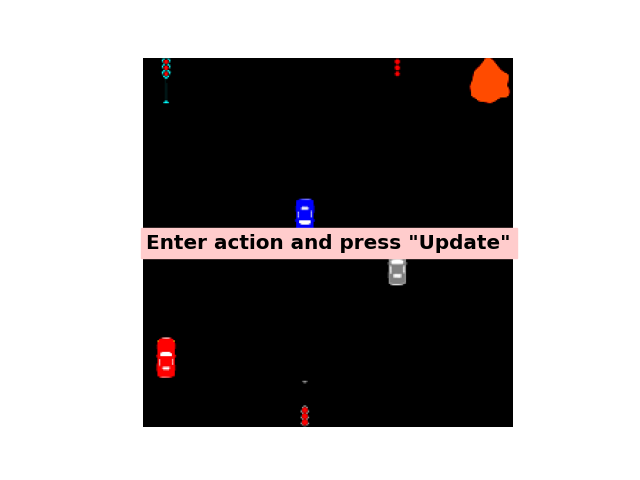

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You performed no action.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: you quickly move the orange obstacle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: you quickly move the orange obstacle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: you quickly move the orange obstacle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: you quickly move the orange obstacle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: you quickly move the orange obstacle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: you quickly move the orange obstacle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: you quickly move the orange obstacle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: you quickly move the orange obstacle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You move the blue vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You move the blue vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You move the blue vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You move the blue vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You move the blue vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You move the blue vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You move the blue vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You move the blue vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You move the blue vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You move the silver vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You move the silver vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You move the silver vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You move the silver vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You move the silver vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You move the silver vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You move the silver vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You move the silver vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You move the silver vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You move the silver vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You move the silver vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You move the silver vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You move the silver vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You move the silver vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You move the silver vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You move the silver vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You move the silver vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You move the silver vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You move the silver vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You move the silver vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You move the silver vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You move the silver vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You move the silver vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You move the silver vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You move the silver vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You move the silver vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You move the silver vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You move the silver vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You move the silver vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You move the silver vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You move the silver vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You move the silver vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You move the silver vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You move the silver vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You move the silver vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You move the silver vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You move the silver vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You move the silver vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You move the silver vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You move the silver vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You changed the state of the cyan traffic light.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You performed no action.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You moved the red vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You moved the red vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You moved the red vehicle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You performed no action.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You performed no action.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You performed no action.


In [ ]:
%matplotlib ipympl
import ipywidgets as widgets
from IPython.display import display
import torch
import matplotlib.pyplot as plt
# from open_clip import get_tokenizer
from transformers import AutoTokenizer
# tokenizer = get_tokenizer('hf-hub:timm/ViT-B-16-SigLIP')
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
action = torch.tensor((-0.14285714, -0.14285714)).to(device)

# Assuming test_seq_dataset, next_step_prediction, and device are defined elsewhere
latents = None
image = test_seq_dataset[0][0][0]


fig, ax = plt.subplots()
ax.imshow(image.permute(1, 2, 0).cpu().numpy())
load_text = ax.text(image.shape[-1]//2, 
                    image.shape[-2]//2, 
                    'Enter action and press "Update"', 
                    fontsize='x-large',
                    weight='bold',
                    va='center',
                    ha='center',
                    backgroundcolor=(1.0, 0.8, 0.8))
load_text.set_visible(True)  # Initially visible to prompt for input
ax.axis('off')

# Text input for action
text_input = widgets.Text(
    value='',
    placeholder='Type action here',
    description='Action:',
    disabled=False
)

# Button to trigger the update
update_button = widgets.Button(
    description='Update',
    disabled=False,
    button_style='',  # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to update based on action',
    icon='check'  # (FontAwesome names without the `fa-` prefix)
)

def on_update_button_clicked(b):
    global image, latents
    text = text_input.value 
    
    
    print(f'Action: {text}') 

    # Update the image and latents based on the provided action
    image, latents = next_step_prediction(model,
                                          image=image,
                                          action=action,  # Assuming the function now accepts a string
                                          latents=latents,
                                          plot_images=False,
                                          text=text,
                                          tokenizer=tokenizer,
                                          text_only=True)
                                          
    
    # Update the plot with the new image
    ax.clear()  # Clear the previous image
    ax.imshow(image.permute(1, 2, 0).cpu().numpy())
    load_text.set_visible(False)  # Hide the loading text
    ax.axis('off')  # Hide axes again after redrawing
    fig.canvas.draw()  # Refresh the figure

update_button.on_click(on_update_button_clicked)

# Display the widgets
widgets.VBox([text_input, update_button])

In [ ]:
causal_dicts

In [ ]:
# list(map(get_color_name, [eval(x.split('_')[1]) for x in causal_dicts[0].keys()]))
# Replace the rgb values with the color names in the causal_dicts keys while keeping the rest of the key intact
# i.e., 'obstacle_(255, 165, 0)_position_x' -> 'obstacle_orange_position_x'
plt.imshow(frame1, origin='upper', interpolation='none')
# Remove the axes and the white space around the image
plt.gca().set_axis_off()
# Remove the white space around the image
plt.tight_layout()
plt.show()


In [ ]:
plt.imshow(frame2, origin='upper', interpolation='none')
# Remove the axes and the white space around the image
plt.gca().set_axis_off()
# Remove the white space around the image
plt.tight_layout()
plt.show()

In [ ]:

from models.ae import Autoencoder

import io
import base64
import torch
import numpy as np
from PIL import Image
from dash import Dash, dcc, html, Input, Output, no_update, callback
import plotly.graph_objects as go
from sklearn.manifold import TSNE
import umap.umap_ as umap
import io
import base64
import dash

# Helper functions
def np_image_to_base64(img):
    """Convert a NumPy array to a base64 encoded image."""
    img = Image.fromarray((img * 255).astype(np.uint8))
    buffered = io.BytesIO()
    img.save(buffered, format="PNG")
    return f"data:image/png;base64,{base64.b64encode(buffered.getvalue()).decode()}"

# Main function to prepare data and create Dash app
def create_visualizations_app(model, dataloader, perplexity=30, n_neighbors=15, min_dist=0.1, max_samples=500):
    model.eval()
    embeddings, images, frame_positions = [], [], []
    sample_count = 0

    # Collect data
    with torch.no_grad():
        for batch in dataloader:
            imgs, positions, *_ = batch  # Update this based on your data structure
            if imgs.dim() > 4:
                imgs = imgs.view(-1, *imgs.shape[2:])
                positions = positions.view(-1)

            if sample_count + imgs.shape[0] > max_samples:
                limit = max_samples - sample_count
                imgs = imgs[:limit]
                positions = positions[:limit]

            embeddings_batch = model(imgs.to('cuda')).cpu().numpy()  # Ensure device compatibility
            embeddings.append(embeddings_batch)
            images.extend([np_image_to_base64(np.array(img.permute(1, 2, 0))) for img in imgs])
            frame_positions.extend(positions.cpu().numpy())

            sample_count += imgs.shape[0]
            if sample_count >= max_samples:
                break

    embeddings = np.concatenate(embeddings, axis=0)
    colors = frame_positions / np.max(frame_positions)  # Normalize for color mapping

    # Perform dimensionality reduction
    tsne = TSNE(n_components=2, perplexity=perplexity).fit_transform(embeddings)
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=2)
    umap_result = reducer.fit_transform(embeddings)

    # Create Dash app
    app = Dash(__name__)

    app.layout = html.Div([
        dcc.Graph(id="graph-tsne", figure=create_figure(tsne, images, frame_positions, 't-SNE Visualization')),
        dcc.Graph(id="graph-umap", figure=create_figure(umap_result, images, frame_positions, 'UMAP Visualization')),
        dcc.Tooltip(id="graph-tooltip")
    ])

    @callback(
        Output("graph-tooltip", "show"),
        Output("graph-tooltip", "bbox"),
        Output("graph-tooltip", "children"),
        Input("graph-tsne", "hoverData"),
        Input("graph-umap", "hoverData")
    )
    def display_hover(hoverData_tsne, hoverData_umap):
        ctx = dash.callback_context

        if not ctx.triggered:
            return False, no_update, no_update

        hover_data = ctx.triggered[0]["value"]["points"][0]
        bbox = hover_data["bbox"]
        num = hover_data["pointNumber"]

        children = html.Div([
            html.Img(src=images[num], style={"width": "100px", 'display': 'block', 'margin': '0 auto'}),
            # html.P(f"Frame Position: {frame_positions[num]}", style={'font-weight': 'bold'})
        ])

        return True, bbox, children

    return app

def create_figure(data, images, frame_positions, title):
    fig = go.Figure(data=[go.Scatter(
        x=data[:, 0],
        y=data[:, 1],
        mode='markers',
        marker=dict(size=5, color=frame_positions, colorscale='Viridis', showscale=True),
        text=[f'' for img, pos in zip(images, frame_positions)],
        hoverinfo='text'
    )])
    fig.update_layout(title=title, xaxis_title=f'{title} Dimension 1', yaxis_title=f'{title} Dimension 2')
    return fig

model = Autoencoder.load_from_checkpoint('/home/john/PhD/BISCUIT/pretrained_models/epoch=14-step=8325.ckpt')
from experiments.datasets import GridworldDataset
data_folder = '/home/john/PhD/BISCUIT/data_generation/data/gridworld_simplified_2c2b2l_noturn_noshufflecars_bfix_preintv'
train_seq_dataset = GridworldDataset(
        data_folder=data_folder, split='val', return_targets=True, return_latents=True, single_image=False, triplet=False, seq_len=2, cluster=False, return_text=False, subsample_percentage=1.0, return_whole_episode=True)
train_seq_dataloader = torch.utils.data.DataLoader(train_seq_dataset, batch_size=64, shuffle=False, num_workers=4)

# Run the app
app = create_visualizations_app(model, train_seq_dataloader, perplexity=30, n_neighbors=100, min_dist=0.1, max_samples=300)
app.run_server(debug=True, port=8050, host='0.0.0.0')

In [8]:
import re

def extract_goals(example, return_raw=False):
    """Extract the goals from the example.
    
    :param example: dict with 'question' key containing goal and plan statements
    :param return_raw: if True, returns the raw goal statement
    :return: Either raw goal string or parsed goals as a dictionary
    """
    goal_statement = example["question"].split("[STATEMENT]")[-1]\
        .split("My goal is to ")[1].split("My plan is as follows")[0].strip()
    
    if return_raw:
        return goal_statement
    
    # Improved regular expression to extract goal elements (entity, attribute, value)
    pattern = r"(\w+)\s(\w+\s\w+)\sis\s([\d\.]+)(?=\,|\s|$)"
    goals = {match.group(1) + ' ' + match.group(2): float(match.group(3).rstrip('.')) for match in re.finditer(pattern, goal_statement)}
    
    return goals

def goal_check(goals, description, epsilon=0.07, ignore_obstacles=False):
    """Check if the description matches the goals with a tolerance and return the percentage of goals met.
    
    :param goals: dictionary of goal states
    :param description: description string containing current states
    :param epsilon: tolerance for numeric comparisons
    :param ignore_obstacles: if True, obstacle positions are ignored in the check
    :return: Tuple (boolean, float) where boolean is True if all goals are met within tolerance, and float is the percentage of goals met
    """
    # Parse the description into a dictionary
    pattern = r"(\w+)\s(\w+\s\w+)\sis\s([\d\.]+)(?=\,|\s|$)"
    current_states = {match.group(1) + ' ' + match.group(2): float(match.group(3).rstrip('.')) for match in re.finditer(pattern, description)}
    
    total_goals = 0
    met_goals = 0
    for key, goal_value in goals.items():
        if ignore_obstacles and 'obstacle' in key:
            continue
        total_goals += 1
        if key in current_states and (abs(current_states[key] - goal_value) <= epsilon):
            met_goals += 1

    all_goals_met = met_goals == total_goals
    percentage_met = (met_goals / total_goals) * 100 if total_goals > 0 else 0
    return all_goals_met, percentage_met

# Testing
example = {
    "question": "[STATEMENT] This is the context. My goal is to orange obstacle position x is 1.0, orange obstacle position y is 0.86, cyan trafficlight state is 0.00, olive trafficlight state is 1.00, silver trafficlight state is 0.00, blue vehicle position y is 0.86, silver vehicle position y is 0.71, red vehicle position y is 0.14. My plan is as follows: execute movement."
}
description = "orange obstacle position x is 0.57, orange obstacle position y is 0.86, cyan trafficlight state is 0.00, olive trafficlight state is 1.00, silver trafficlight state is 0.00, blue vehicle position y is 0.86, silver vehicle position y is 0.71, red vehicle position y is 0.14."

goals = extract_goals(example)
result = goal_check(goals, description, ignore_obstacles=True)
result

(True, 100.0)